# Building Demand Method 1

#### Brief overview:

The energy demand for each cell is assessed according to the following parameters:
𝐵 Number of buildings
𝑆𝑟𝑒𝑠 Share of res buildings
𝑁 Nb of HH per res buildings
𝑎 Electrified status (probability)
𝐸_𝐻𝐻  Energy consumption per HH
𝑟 Adjustment with RWI

For each cell c, we have 𝐷_𝑐=𝐵_𝑐∗𝑆𝑟𝑒𝑠∗𝑁_𝑐  ∗𝑎_𝑐  ∗𝐸_𝐻𝐻  ∗𝑟_𝑐 

### Import necessary modules

In [1]:
# Check if we are running the notebook directly, if so move workspace to parent dir
import sys
import os
currentdir = os.path.abspath(os.getcwd())
if os.path.basename(currentdir) != 'DemandMappingZambia':  
  sys.path.insert(0, os.path.dirname(currentdir))
  os.chdir('..')
  print(f'Move to {os.getcwd()}')

Move to C:\Users\amillot\PycharmProjects\DemandMappingZambia


In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona


# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

%matplotlib inline

In [3]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.4f}'.format

In [4]:
from utils import processing_raster, finalizing_rasters

### Define directories and dataset names

In [5]:
### Define directories and dataset names

ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs"

## RWI layer
rwi_path = in_path + "/Residential/Data/WealthIndex"
rwi_name = 'zmb_relative_wealth_index.csv'

In [6]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

### Import layers to be used

In [7]:
## Import Relative Wealth Index | convert to geodf | export as gpkg
rwi = pd.read_csv(rwi_path + "/" + rwi_name)
rwi_gdf = gpd.GeoDataFrame(rwi, geometry=gpd.points_from_xy(rwi.longitude, rwi.latitude), crs={'init': 'epsg:4326'})
rwi_gdf.to_file(os.path.join(rwi_path,"{c}".format(c=rwi_name.split(".")[0])), driver="GPKG")

In [8]:
hexagons = gpd.read_file(out_path + "\\" + "h3_grid_at_hex_7.shp")

In [9]:
grid = hexagons

In [10]:
adm = grid["ADM1_NAME"].unique()
adm = adm[0]

## Extract raster values to hexagons

Extract count of buildings per hex from WorldPop

In [11]:
pathWorldPopBuiCount = "Residential/Data/WorldPop/Copperbelt_buildings_v2_0_count.tif"
# grid = processing_raster("buildings", "count", grid, filepath=pathWorldPopBuiCount)
grid = processing_raster("buildings", "sum", grid, filepath=pathWorldPopBuiCount) #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/

2023-08-23 17:38:32.380385


Extract population density from WorldPop

In [12]:
pathWorldPopPopCount = "Residential/Data/WorldPop/Copperbelt_population_v1_0_gridded.tif"
grid = processing_raster("popDens", "sum", grid, filepath=pathWorldPopPopCount) #Copperbelt_population_v1_0_gridded from https://apps.worldpop.org/peanutButter/

2023-08-23 17:38:57.446828


Extract urban areas from WorldPop

In [13]:
pathWorldPopBuiUrban = "Residential/Data/WorldPop/Copperbelt_buildings_v2_0_urban.tif"
grid = processing_raster("locationWP", "median", grid, filepath=pathWorldPopBuiUrban)      #Copperbelt_population_v1_0_gridded from https://apps.worldpop.org/peanutButter/

2023-08-23 17:39:21.945071


Extract urbanisation level GHSL

In [14]:
# GHS Settlement Model grid (R2023) https://ghsl.jrc.ec.europa.eu/download.php?ds=smod
pathGHSMod ="Residential/Data/GHSL/Copperbelt_GHS_SMOD_E2020_GLOBE_R2023A_R11C21.tif"
grid = processing_raster("SMOD", "median", grid, filepath=pathGHSMod)  

2023-08-23 17:39:39.933497


Extract other data from GHSL

In [15]:
pathGHSL ="Residential/Data/GHSL/Copperbelt_GHS_BUILT_S_E2020_GLOBE_R2023A_R11C21.tif"
grid = processing_raster("STot", "sum", grid, filepath=pathGHSL)  

2023-08-23 17:39:57.683375


In [ ]:
pathGHSL ="Residential/Data/GHSL/Copperbelt_GHS_BUILT_S_NRES_E2020_GLOBE_R2023A_R11C21.tif"
grid = processing_raster("SNRes", "sum", grid, filepath=pathGHSL)  

In [16]:
pathGHSL ="Residential/Data/GHSL/Copperbelt_GHS_BUILT_V_E2020_GLOBE_R2023A_R11C21.tif"
grid = processing_raster("VTot", "sum", grid, filepath=pathGHSL)  

2023-08-23 17:40:15.291575


In [17]:
pathGHSL ="Residential/Data/GHSL/Copperbelt_GHS_BUILT_V_NRES_E2020_GLOBE_R2023A_R11C21.tif"
grid = processing_raster("VNRes", "sum", grid, filepath=pathGHSL)  

2023-08-23 17:40:32.912255


In [19]:
## Average of the Net Building Height (ANBH)
## Link: https://ghsl.jrc.ec.europa.eu/ghs_buH2023.php
pathGHSANBH = "Residential/Data/GHSL/Copperbelt_HANBH_2018_R11C21.tif"
grid = processing_raster("ANBH", "mean", grid, filepath=pathGHSANBH)

2023-08-23 17:41:15.326972


Extract lighing data

In [20]:
## set_lightscore_sy_xxxx.tif: Predicted likelihood that a settlement is electrified (0 to 1)
## http://www-personal.umich.edu/~brianmin/HREA/data.html
pathHREA = "Residential/Data/Copperbelt_set_lightscore_sy_2019.tif"
grid = processing_raster("HREA", "mean", grid, filepath=pathHREA)
columnProbElec= "HREA"

2023-08-23 17:41:47.206091


Extract RWI

In [21]:
# Relative Wealth Index (RWI) -- extracting the mean value per building
# Link: https://gee-community-catalog.org/projects/rwi/
pathRWI = "Residential/Data/WealthIndex/rwi_map.tif"
grid = processing_raster("rwi", "mean", grid, filepath=pathRWI)

# ## Run the extraction
# #grid.drop(['rwi'], axis=1, inplace=True) ##uncomment if you want to rerun
# columnNameRWI = "rwi"
# grid = spatialjoinvectors("RWI", columnNameRWI, admin_gdf, crs_WGS84, grid, 'mean')
# averageRwi = grid[columnNameRWI].mean()
# print(averageRwi)
# grid[columnNameRWI] = grid[columnNameRWI].fillna(averageRwi)

2023-08-23 17:42:08.448437


##### Once done with rasters run this cell

In [22]:
grid = finalizing_rasters(out_path, grid, crs_proj)

2023-08-23 17:42:11.084839


In [23]:
grid.rename({'HREAmean': 'HREA'}, axis=1, inplace=True)
grid.rename({'rwimean': 'rwi'}, axis=1, inplace=True)
grid.rename({'SMODmedian': 'SMOD'}, axis=1, inplace=True)
grid.rename({'popDenssum': 'popDens'}, axis=1, inplace=True)
grid.rename({'locationWPmedian': 'locationWP'}, axis=1, inplace=True)
grid.rename({'STotsum': 'STot'}, axis=1, inplace=True)
grid.rename({'SNRessum': 'SNRes'}, axis=1, inplace=True)
grid.rename({'VTotsum': 'VTot'}, axis=1, inplace=True)
grid.rename({'VNRessum': 'VNRes'}, axis=1, inplace=True)
grid.rename({'ANBHmean': 'ANBH'}, axis=1, inplace=True)

Add values in RWi column when there is none

In [24]:
grid["rwi"].fillna(grid["rwi"].mean(numeric_only=True).round(1), inplace=True)

In [25]:
grid.head(3)

,hexagons,lon,lat,index_righ,ADM1_NAME,id,buildingssum,popDens,locationWP,SMOD,STot,VTot,VNRes,ANBH,HREA,rwi,geometry
0,875534c4affffff,28.0948,-12.8166,0.0000,COPPERBELT,1,666.0000,"1,025.2228",1.0000,NaN,NaN,NaN,NaN,NaN,0.9998,0.4475,"POLYGON ((28.10763 -12.82099, 28.09756 -12.831..."
1,873996584ffffff,28.6011,-12.8953,0.0000,COPPERBELT,2,579.0000,"1,096.1873",1.0000,NaN,NaN,NaN,NaN,NaN,1.0000,0.2095,"POLYGON ((28.61394 -12.89978, 28.60386 -12.910..."
2,875534012ffffff,27.8809,-12.8253,0.0000,COPPERBELT,3,71.0000,170.4483,0.0000,NaN,NaN,NaN,NaN,NaN,0.1885,0.1465,"POLYGON ((27.89371 -12.82973, 27.88364 -12.840..."


GHSL data analysis

In [ ]:
# total surface of the buildings
totalSurface =  grid["STot"].sum()
# total residential surface of the buildings
totalNResSurface =  grid["SNRes"].sum()
totalResSurface =  totalSurface - totalNResSurface
# share of res buidlings surface
shareResSurface = totalResSurface/totalSurface
# comparison height computed with ANBH
grid["HeightB"] = grid["VTot"]/grid["STot"]

## Compute residential demand

In [21]:
# Retrieve values from the MTF survey
%run Residential/energy_demand_res.ipynb
energyConsHH = energycons_res_mtf["annual"] # dictionnary for each region one value
energyConsHH

Electricity consumption : 4,022,500,000 MWh
Electricity consumption : 4,022 TWh


CENTRAL         1,558
COPPERBELT      3,093
EASTERN         1,260
LUAPULA         2,630
LUSAKA          2,982
NORTH WESTERN   2,172
SOUTHERN        1,742
WESTERN           288
TOTAL           2,710
Name: annual, dtype: float64

In [22]:
# electrified or non-electrified status
grid["Status_electrified"] = grid.apply(lambda row: ("elec" if ((row[columnProbElec] > 0))
                                             else "nonelec"), axis=1)
grid["Status_electrified"].value_counts()

Status_electrified
elec       4410
nonelec     756
Name: count, dtype: int64

Determine location (ruban or rural) of each cell

In [23]:
# for each hexagon, determine if it's rural or urban --> choose best source
grid["locAssessed"] = grid.apply(lambda row: ("urban" if ((row['buildingssum'] > 1000)) # number chosen to get 1 for nb of HH per rural building
                                             else "rural"), axis=1)
grid["locWorldPop"] = grid.apply(lambda row: ("urban" if ((row['locationWP'] == 1)) 
                                             else "rural"), axis=1)
grid["locGHSL"] = grid.apply (lambda row: ("urban" if ((row['SMOD'] == 30) or (row['SMOD'] == 21) or (row['SMOD'] == 22) or (row['SMOD' ] == 23)) 
                                             else "rural"), axis=1)
grid["location"] = grid["locWorldPop"] 

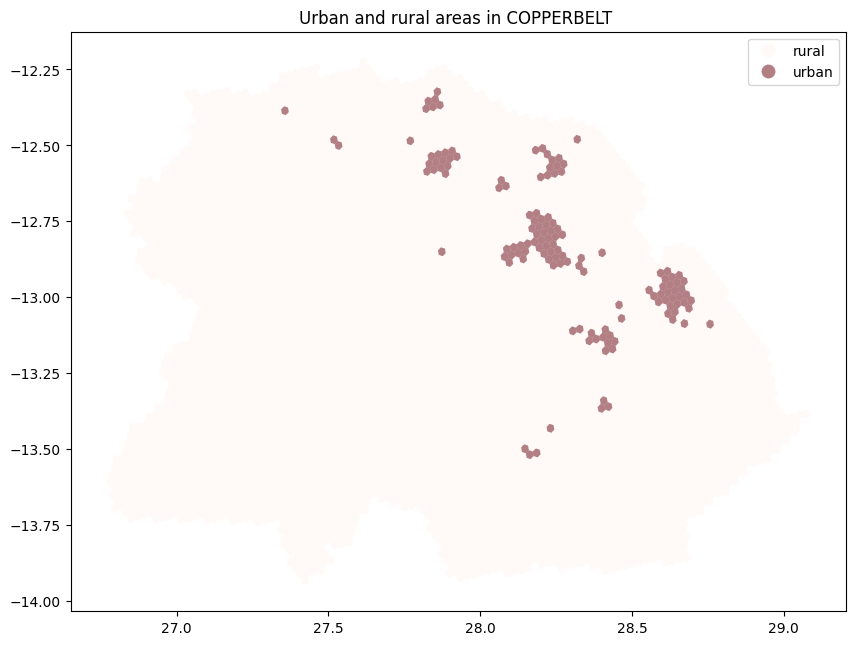

In [39]:
# map of the urban and rural areas Assessed
# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))
# Plot
grid.sort_values('locAssessed', ascending=True).plot(
    ax=ax, column='locAssessed', cmap="Reds", legend=True, alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Urban and rural areas in {} '.format(adm) )

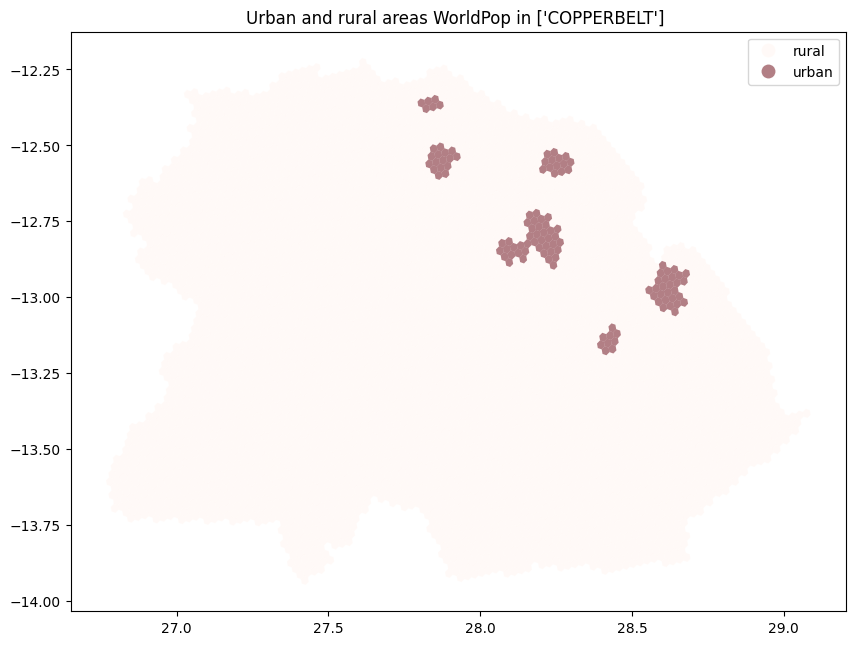

In [25]:
# map of the urban and rural areas WorldPop
# Create the axis first
fig2, ax2 = plt.subplots(figsize=(10, 10))
# Plot
grid.sort_values('locWorldPop', ascending=True).plot(
    ax=ax2, column='locWorldPop', cmap="Reds", legend=True, alpha=0.5)

ax2.set_aspect('equal', 'box')
txt = ax2.set_title('Urban and rural areas WorldPop in {} '.format(adm) )

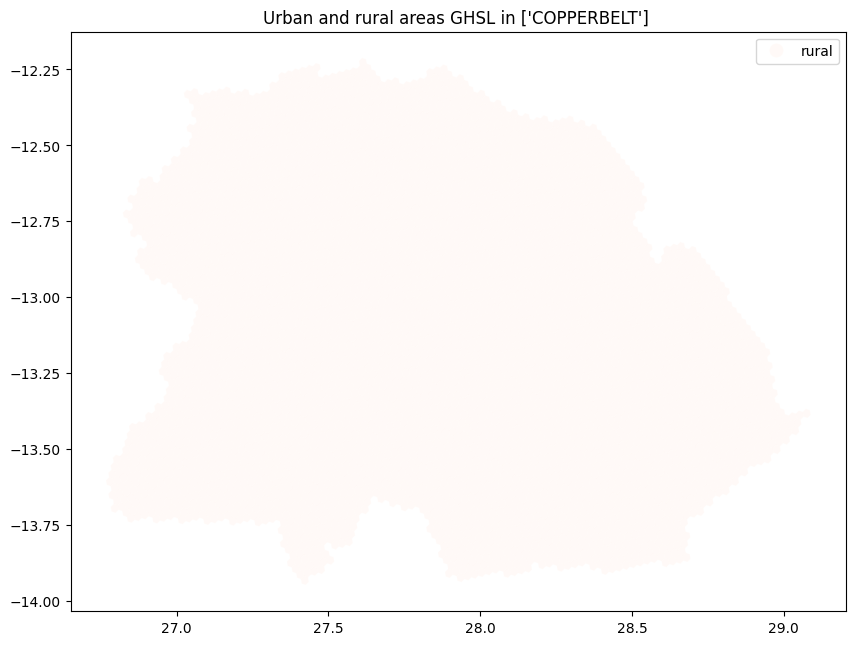

In [26]:
# map of the urban and rural areas
# Create the axis first
fig3, ax3 = plt.subplots(figsize=(10, 10))
# Plot
grid.sort_values('locGHSL', ascending=True).plot(
    ax=ax3, column='locGHSL', cmap="Reds", legend=True, alpha=0.5)

ax3.set_aspect('equal', 'box')
txt = ax3.set_title('Urban and rural areas GHSL in {} '.format(adm) )

Assess number of residential households per cell

In [40]:
# Option 1: use buildings count from Worldpop
# total number of buildings
totalBuildings = grid["buildingssum"].sum()
urbanBuildings = np.where((grid['location'] == "urban"),grid[['buildingssum']].sum(axis=1), 0).sum()
ruralBuildings = np.where((grid['location'] == "rural"),grid[['buildingssum']].sum(axis=1), 0).sum()
print("total Buildings:",f"{totalBuildings:,.0f}", "urban:",f"{urbanBuildings:,.0f}", "rural:",f"{ruralBuildings:,.0f}")
shareRuralBuild = ruralBuildings/totalBuildings
shareUrbanBuild = urbanBuildings/totalBuildings
print("share Build urban:", f"{shareUrbanBuild:.0%}","rural:",f"{shareRuralBuild:.0%}")
resHHurban = 449077  # assessment for 2019 from the Census data 2022
resHHrural = 85356 # assessment for 2019 from the Census data 2022
# shareResBuildings = {"urban": 0.80, "rural": 0.99} # --> to change!
shareResBuildings = {"urban": 0.50, "rural": 0.17} # --> to change! # number chosen to get 1 for nb of HH per rural building
resUrbanBuildings = urbanBuildings*shareResBuildings["urban"]
resRuralBuildings = ruralBuildings*shareResBuildings["rural"]
resTotalBuildings = resUrbanBuildings + resRuralBuildings
print("total Res Buildings:",f"{resTotalBuildings:,.0f}", "urban:",f"{resUrbanBuildings:,.0f}", "rural:",f"{resRuralBuildings:,.0f}")
nbOfHHperResBuilding =  {"urban": 1, "rural": 1} # init
nbOfHHperResBuilding["urban"]= resHHurban/resUrbanBuildings
nbOfHHperResBuilding["rural"]= resHHrural/resRuralBuildings
print("nb Of HH per Res Building: urban", f"{nbOfHHperResBuilding['urban']:,.1f}","rural", f"{nbOfHHperResBuilding['rural']:,.1f}")
totalResHHurban = nbOfHHperResBuilding["urban"]*urbanBuildings*shareResBuildings["urban"]
totalResHHrural = nbOfHHperResBuilding["rural"]*ruralBuildings*shareResBuildings["rural"]
totalResHH = totalResHHurban + totalResHHrural
print("total Res HH: urban", f"{totalResHHurban:,.0f}", "rural", f"{totalResHHrural:,.0f}")
nbOfHHperResBuilding_average = totalResHH / ((urbanBuildings*shareResBuildings["urban"]) +(ruralBuildings*shareResBuildings["rural"]))
print("nb Of HH per Res Building average", f"{nbOfHHperResBuilding_average:,.1f}")
# Compute the nb of HH per cell
grid["ResHH_urban"]=np.where( (grid['location'] == "urban"), grid[['buildingssum']].sum(axis=1), 0)*shareResBuildings["urban"]*nbOfHHperResBuilding["urban"]
grid["ResHH_rural"]=np.where( (grid['location'] == "rural"), grid[['buildingssum']].sum(axis=1), 0)*shareResBuildings["rural"]*nbOfHHperResBuilding["rural"]

total Buildings: 1,104,219 urban: 604,165 rural: 500,054
share Build urban: 55% rural: 45%
total Res Buildings: 387,092 urban: 302,082 rural: 85,009
nb Of HH per Res Building: urban 1.5 rural 1.0
total Res HH: urban 449,077 rural 85,356
nb Of HH per Res Building average 1.4


In [28]:
# Option 2 use population estimates from Worldpop
# compute total pop from world pop
totalPop=grid["popDens"].sum()
# Compare to Zamstats
totalPopStats= 2513919
print("total population: WorldPop", f"{totalPop:,.0f}", "Census", f"{totalPopStats:,.0f}")
pplperHH_urban = 4.67  
pplperHH_rural = 5.14
# Compute the nb of HH per cell
grid["ResHHWorldPop2_urban"]=np.where( (grid['location'] == "urban"), grid[['popDens']].sum(axis=1), 0)/pplperHH_urban
grid["ResHHWorldPop2_rural"]=np.where( (grid['location'] == "rural"), grid[['popDens']].sum(axis=1), 0)/pplperHH_rural

total population: WorldPop 2,888,252 Census 2,513,919


Assess number of residential households per cell with access to electricity

In [29]:
# for each hexagon, assessment of the number of HH
access_elec = {"elec": 0, "nonelec": 1}
# sizeHH = {"urban": 4.7, "rural": 5.2} #https://population.un.org/Household/index.html#/countries/ https://dhsprogram.com/publications/publication-fr361-dhs-final-reports.cfm
#print(grid["Location"].map(shareResBuildings))
#grid["ResHHNbWithAccess"]=grid["buildingscount"]*grid["Location"].map(shareResBuildings)*grid["Status_electrified"].map(access_elec)

grid["ResHHNbWithAccessUrb"] = np.where((grid['Status_electrified'] == "elec") & (grid['location'] == "urban"),
                                                                            grid[['buildingssum']].sum(axis=1), 0)*shareResBuildings["urban"]*nbOfHHperResBuilding["urban"]* grid[columnProbElec]
                                        
grid["ResHHNbWithAccessRur"] = np.where((grid['Status_electrified'] == "elec") & (grid['location'] == "rural"),
                                                                            grid[['buildingssum']].sum(axis=1), 0)*shareResBuildings["rural"]*nbOfHHperResBuilding["rural"]* grid[columnProbElec]

grid["ResHHNbWithAccess"] = grid[["ResHHNbWithAccessUrb", "ResHHNbWithAccessRur"]].sum(axis=1)

totalResHHWithAccessUrb = grid["ResHHNbWithAccessUrb"].sum()
totalResHHWithAccessRur = grid["ResHHNbWithAccessRur"].sum()
totalResHHWithAccess = grid["ResHHNbWithAccess"].sum()
print("totalResHHWithAccessUrb:",f"{totalResHHWithAccessUrb:,.0f}")
print("totalResHHWithAccessRur:",f"{totalResHHWithAccessRur:,.0f}")
print("totalResHHWithAccess:",f"{totalResHHWithAccess:,.0f}")
# print(grid["ResHHNbWithAccessUrb"].sum() , grid["ResHHNbWithAccessRur"].sum(), grid["ResHHNbWithAccess"].sum())
grid.head(2)

totalResHHWithAccessUrb: 449,039
totalResHHWithAccessRur: 47,808
totalResHHWithAccess: 496,847


,hexagons,lon,lat,index_righ,ADM1_NAME,id,buildingssum,popDens,locationWP,SMOD,...,locWorldPop,locGHSL,location,ResHH_urban,ResHH_rural,ResHHWorldPop2_urban,ResHHWorldPop2_rural,ResHHNbWithAccessUrb,ResHHNbWithAccessRur,ResHHNbWithAccess
0,873469a43ffffff,29,-13,0,COPPERBELT,1,57,126,0,NaN,...,rural,rural,rural,0,10,0,25,0,7,7
1,875536acdffffff,27,-13,0,COPPERBELT,2,4,10,0,NaN,...,rural,rural,rural,0,1,0,2,0,0,0


Compute the resulting access rate

In [30]:
# access rate for HH
accessRateHH = totalResHHWithAccess/totalResHH
print(accessRateHH)
# access rate for population
accessRatePop = (totalResHHWithAccessUrb*pplperHH_urban+totalResHHWithAccessRur*pplperHH_rural)/totalPopStats
print(accessRatePop)

0.9296706723208484
0.9319089317168318


Compute the energy consumption assessment per cell

In [31]:
# Energy Consumption assessment per cell
averageRwi = grid['rwi'].mean()
print(averageRwi)
grid["ResEnergyCorrPerHH"] = abs(grid['rwi']/averageRwi)*grid["ADM1_NAME"].map(energyConsHH)
grid["ResEnergy"] = grid["ResHHNbWithAccess"] * grid["ResEnergyCorrPerHH"] * grid[columnProbElec]
grid.to_csv("data.csv")
grid.to_file(out_path + "\\" + 'res_energy_map.shp', index=False)
grid.head(3)

-0.2856472189317789


,hexagons,lon,lat,index_righ,ADM1_NAME,id,buildingssum,popDens,locationWP,SMOD,...,location,ResHH_urban,ResHH_rural,ResHHWorldPop2_urban,ResHHWorldPop2_rural,ResHHNbWithAccessUrb,ResHHNbWithAccessRur,ResHHNbWithAccess,ResEnergyCorrPerHH,ResEnergy
0,873469a43ffffff,29,-13,0,COPPERBELT,1,57,126,0,NaN,...,rural,0,10,0,25,0,7,7,"4,219","20,071"
1,875536acdffffff,27,-13,0,COPPERBELT,2,4,10,0,NaN,...,rural,0,1,0,2,0,0,0,"3,248",0
2,87553411bffffff,28,-13,0,COPPERBELT,3,151,361,0,NaN,...,rural,0,26,0,70,0,14,14,"3,354","24,203"


In [32]:
total_residentialenergy_assessed = grid["ResEnergy"].sum()
print("residential electricity consumption:", f"{total_residentialenergy_assessed/10**6:,.0f}","GWh") # GWh

residential electricity consumption: 4,367 GWh
